In [1]:
%matplotlib inline

# Data analysis code

We will use this notebook as a basis for running analyses on some data of interest. There are a lot of underlying assumptions about statistics that we don't have the time to get into (there are entire courses in college for this!) so this is essentially just giving us what the code to run should be. 

Before we start running our own data, we'll use some N170 data that was previously collected to familiarize ourselves with the process.

In [1]:
import os, numpy as np,pandas as pd
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import math

# MNE functions
import mne
from mne import Epochs,find_events
from mne.decoding import Vectorizer

# EEG-Notebooks functions
from eegnb.analysis.utils2 import load_data,plot_conditions,plot_highlight_regions
from eegnb.datasets import fetch_dataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import ttest_ind

## EEG data: Visualization

The visualization that we've already done for the N170 and P300 notebooks is our starting point. The visuals alone can actually tell us something about the areas that we'll be measuring! We'll start by looking at the 'raw data' (i.e. the data before we do any filtering and removing parts that aren't as good).

### Loading data

In [19]:
# loading the data block of choice. We'll start with one participant at a time:

eegnb_data_path = os.path.join(os.path.expanduser('~/'),'.eegnb', 'data')    

# to load data from a specific subject and session:
subject = 1
session = 1

# make sure that these numbers are correct, or it will run from the last time you used 'subject' and 'session', 
# including from above!

raw = load_data(subject,session,
                experiment='visual-N170', site='local', device_name='muse2_bfn',
                data_dir = eegnb_data_path)

['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=61657
    Range : 0 ... 61656 =      0.000 ...   240.844 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=30835
    Range : 0 ... 30834 =      0.000 ...   120.445 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=30879
    Range : 0 ... 30878 =      0.000 ...   120.617 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=30832
    Range : 0 ... 30831 =      0.000 ...   120.434 secs
Ready.
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Creating RawArray with float64 data, n_channels=5, n_times=30828
    Range : 0 ... 30827 =      0.000 ...   

Effective window size : 8.000 (s)
Spectogram using 2048-point FFT on 2048 samples with 0 overlap and hamming window
Generating pos outlines with sphere [0.    0.    0.    0.095] from [0.    0.    0.    0.095] for eeg
Generating coords using: [0.    0.    0.    0.095]


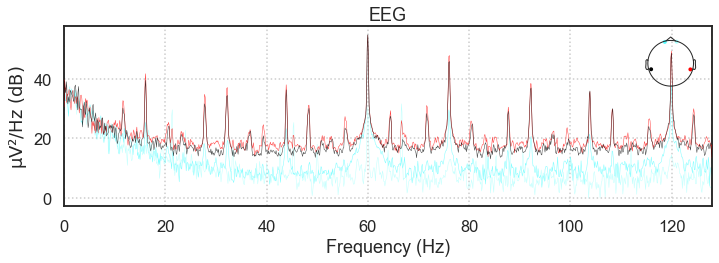

In [20]:
# plotting the raw data
raw.plot_psd(); 

### Filtering the data

We've previously been using a certain command to 'filter' our data. 

Filtering raw data in 8 contiguous segments
Setting up band-pass filter from 1 - 30 Hz
Using filter length: 124876

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Effective window size : 8.000 (s)
Spectogram using 2048-point FFT on 2048 samples with 0 overlap and hamming window
Generating pos outlines with sphere [0.    0.    0.    0.095] from [0.    0.    0.    0.095] for eeg
Generating coords using: [0.    0.    0.    0.095]


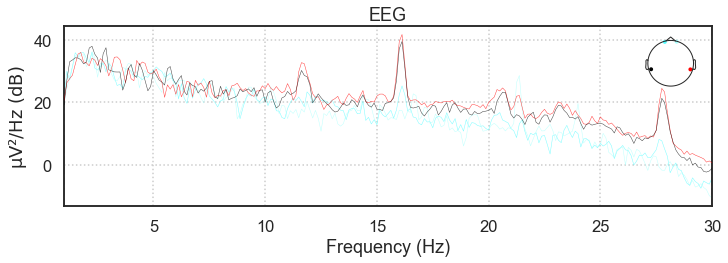

In [23]:
raw.filter(1,30, method='iir')
raw.plot_psd(fmin=1, fmax=30);

### Epoching

A couple of notes about the below block: 

'reject' indicates the voltage change threshold after which we are rejecting a given epoch of data. Remember that blinks are big and actually aren't indicative of what we want to measure!

In [24]:
# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raw)
event_id = {'House': 1, 'Face': 2}

# Create an MNE Epochs object representing all the epochs around stimulus presentation
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 75e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

Trigger channel has a non-zero initial value of -9223372036854775808 (consider using initial_event=True to detect this event)
1346 events found
Event IDs: [ 0  1  2 99]
sample drop %:  5.052005943536408


Number of events,1278
Events,Face: 634House: 644
Time range,-0.102 – 0.801 sec
Baseline,off


### Plotting

The conditions should be named for what you're plotting! For example, in the N170, the code 1 in the data represents when a house was pictured, while the code 2 represents when a face was pictured. However, in the P300, 1 represents a non-target and 2 represents a target.

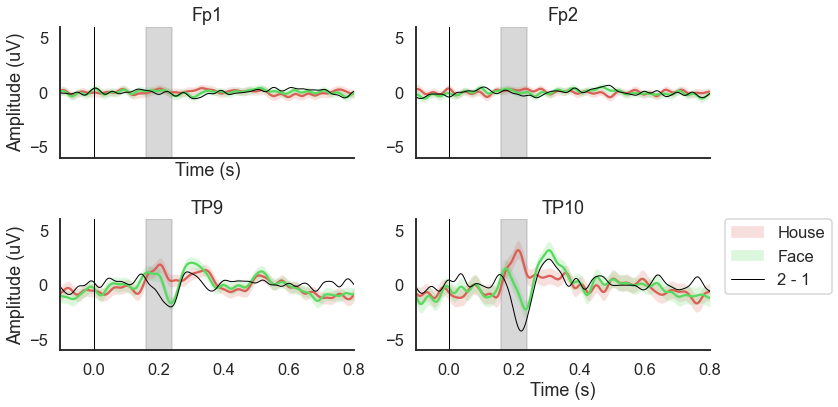

In [26]:
conditions = OrderedDict()
conditions['House'] = [1] 
conditions['Face'] = [2]

fig, ax = plot_conditions(epochs, conditions=conditions, 
                          ci=97.5, n_boot=1000, title='',
                          diff_waveform=(1, 2),
                          channel_order=[1, 0, 2, 3])

for k in range(4):
    ax[k].axvspan(0.16, 0.24, color='grey', alpha=0.3) # highlighting region of interest

We are actually looking forward a couple of things here. 

Is there a fluctuation where you would expect one, based on your study design and what you know? 
Are the faint bars overlapping or not?

After doing a quick look-see, you can tell if your data may or may not be too noisy. But either way, we can then also verify what we're observing by testing it statistically. 

## EEG data: Statistics

What we're trying to do is to see whether what we observe could have just happened by chance or not. For example, is there actually a difference between people looking at faces versus houses, or is it just that the EEG data randomly fluctuated a certain way and it happened to coincide when people looked at faces?

Because we are testing effects on waveforms that other researchers have characterized really well, we already have an idea of when and where the differences should happen. So we can actually just compare within specific blocks of time!

### Descriptive Statistics

There are a couple of things that people are interested in when measuring ERPs, namely the latency (how early the ERP happens) and the amplitude (how big the ERP is). With amplitude, there are also two ways of measuring, either the peak amplitude (the maximum size) or the mean amplitude (the average size over a standardized period of time).

We're going to look at mean amplitude as an initial statistic here. Rossion (2014) states that the N170 is typically observed between 120 and 200 milliseconds.

In [27]:
time_windows = [(.12, .2), (.16, .24), (.20, .28)] # the first window, in seconds, should reflect the start and end time of the typical window of interest; 
# the second is there since the muse has a bit of a delay

elecs = ["TP9", "TP10"] # we already know it mainly happens in the temporal electrodes
index = ['condition', 'epoch', 'time']

print(epochs.to_data_frame(index=index)[elecs])

channel                     TP9       TP10
condition epoch time                      
Face      2     -102   4.227636   0.422946
                -98    3.478456  -4.041080
                -94    2.582587  -8.216358
                -90    1.508345 -11.495770
                -86    0.239661 -13.328906
...                         ...        ...
          1344   785 -16.268914  -8.581026
                 789 -17.690417  -7.449199
                 793 -17.463483  -6.238274
                 797 -15.540632  -5.022116
                 801 -12.215308  -3.767913

[296496 rows x 2 columns]


In [28]:
# we want to calculate things separately for houses and faces, so we need to separate that data accordingly
# epoch_df = epochs[Face].copy().crop(tmin, tmax).to_data_frame(index=index)
faces = epochs['Face']
houses = epochs['House']

printout = "{elec}, time: {tmin}-{tmax} s; faces {A: 3f} uv, houses {B: 3f} uv"

for (tmin, tmax) in time_windows:
    faces_df = faces.copy().crop(tmin, tmax).to_data_frame(index=index)
    houses_df = houses.copy().crop(tmin, tmax).to_data_frame(index=index)
    for elec in elecs:
        # extract data
        A = faces_df[elec].mean()
        B = houses_df[elec].mean()

        # display results
        print_dict = dict(elec=elec, tmin=tmin, tmax=tmax,
                          A=A, B=B)
        print(printout.format(**print_dict))

TP9, time: 0.12-0.2 s; faces  0.627444 uv, houses  0.399403 uv
TP10, time: 0.12-0.2 s; faces  0.201529 uv, houses  0.319662 uv
TP9, time: 0.16-0.24 s; faces  0.282956 uv, houses  1.158164 uv
TP10, time: 0.16-0.24 s; faces -0.153390 uv, houses  1.901680 uv
TP9, time: 0.2-0.28 s; faces -0.245629 uv, houses  0.775103 uv
TP10, time: 0.2-0.28 s; faces -0.408868 uv, houses  1.595440 uv


### Hypothesis Testing

While there are lots of complicated hypothesis tests we could do, we'll stick to a simple one: comparing some of those amplitude values we just got. We might predict that there should be differences in amplitude for ERPs when someone is looking at faces versus houses, for example, because we have precedent for that!

In [29]:
report = "{elec}, time: {tmin}-{tmax} s; t({df})={t_val:.3f}, p={p:.3f}"
print("\nTargeted statistical test results:")

faces = epochs['Face']
houses = epochs['House']

for (tmin, tmax) in time_windows:
    
    faces_df = faces.copy().crop(tmin, tmax).to_data_frame(index=index)
    houses_df = houses.copy().crop(tmin, tmax).to_data_frame(index=index)
    
    for elec in elecs:
        
        A = faces_df[elec]
        B = houses_df[elec]
        
        # conduct t test
        t, p = ttest_ind(A, B)

        # display results
        format_dict = dict(elec=elec, tmin=tmin, tmax=tmax,
                           df=len(epochs.events) - 2, t_val=t, p=p)
        print(report.format(**format_dict))


Targeted statistical test results:
TP9, time: 0.12-0.2 s; t(1276)=2.529, p=0.011
TP10, time: 0.12-0.2 s; t(1276)=-0.970, p=0.332
TP9, time: 0.16-0.24 s; t(1276)=-9.816, p=0.000
TP10, time: 0.16-0.24 s; t(1276)=-17.241, p=0.000
TP9, time: 0.2-0.28 s; t(1276)=-12.263, p=0.000
TP10, time: 0.2-0.28 s; t(1276)=-18.183, p=0.000


### Group Statistics

So far what we've been doing is data from one subject. That's good and all, but we collected data from multiple subjects! All we need to do is take what we've done for one subject and expand it to the entire dataset. 

One simple way of doing this is repeating a similar code that we did above and looping through all the participants. At the end, we can gather all of the averages we've made and average them together!

In [13]:
subs = [1, 2] # put all the numbers of the subjects you have here
face_TP9 = []
face_TP10 = []
house_TP9 = []
house_TP10 = []

time_windows = [(.16, .24)] 
elecs = ["TP9", "TP10"] 
index = ['condition', 'epoch', 'time']

sub_count = 0

for sub in subs:
    print(sub)
    
    sub_count += 1
    
    # load raw file
    raw = load_data(sub,1, # note: this assumes that each participant only has one session
                experiment='visual-N170', site='local', device_name='muse2_bfn',
                data_dir = eegnb_data_path, verbose=0)
    
    # filter data
    raw.filter(1,30, method='iir')
    
    # select events
    events = find_events(raw)
    event_id = {'House': 1, 'Face': 2}
    epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 75e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
    
    # generate mean values
    faces = epochs['Face']
    houses = epochs['House']
    
    for (tmin, tmax) in time_windows:
    
        faces_df = faces.copy().crop(tmin, tmax).to_data_frame(index=index)
        houses_df = houses.copy().crop(tmin, tmax).to_data_frame(index=index)

        for elec in elecs:

            A = faces_df[elec].mean()
            B = houses_df[elec].mean()
            
            if elec == 'TP9':
                face_TP9.append(A)
                house_TP9.append(B)
            elif elec == 'TP10':
                face_TP10.append(A)
                house_TP10.append(B)

1
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Trigger channel has a non-zero initial value of -9223372036854775808 (consider using initial_event=True to detect this event)
1346 events found
Event IDs: [ 0  1  2 99]
2
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10',

In [14]:
# here we are averaging all of the 'mean values' for each participant instead of considering every stimulus epoch separately.
# we can do that, but it's not as reflective of how we typically end up testing our values
# TO DO: figure out how to make a grand average waveform for vis. (I think just concatenating all of the raw epochs should work in theory?)
grandavg_face_TP9 = np.nanmean(face_TP9,0)
grandavg_house_TP9 = np.nanmean(house_TP9,0)
grandavg_face_TP10 = np.nanmean(face_TP10,0)
grandavg_house_TP10 = np.nanmean(house_TP10,0)

t_9, p_9 = ttest_ind(face_TP9, house_TP9)
t_10, p_10 = ttest_ind(face_TP10, house_TP10)

We now have some combined values! This is good. We can see how big the differences are between the mean values we've gotten.

In [15]:
# here we are comparing between conditions (e.g. face vs. house)

print('Face TP9 Mean:', grandavg_face_TP9)
print('House TP9 Mean:', grandavg_house_TP9)
print('t(',len(subs),') =',t_9,', p = ',p_9)

print('Face TP10 Mean:', grandavg_face_TP10)
print('House TP10 Mean:', grandavg_house_TP10)
print('t(',len(subs),') =',t_10,', p = ',p_10)

Face TP9 Mean: 0.5117889659884783
House TP9 Mean: 0.9778954861102851
t( 2 ) = -1.2819954235030275 , p =  0.32837576813836467
Face TP10 Mean: 0.23993273550428953
House TP10 Mean: 1.670938007427921
t( 2 ) = -2.6985073058494224 , p =  0.11426423666638494


### Group Visualization

Now that we have some group data to back up our individual data, can we take a look at the average waveforms? The starting code looks similar:

In [31]:
subs = [1, 2] # put all the numbers of the subjects you have here
subcount = 0
conds = ['House','Face']
epochs = {}

# filter data
for sub in subs:
    raw = load_data(sub,1, # note: this assumes that each participant only has one session
            experiment='visual-N170', site='local', device_name='muse2_bfn',
            data_dir = eegnb_data_path, verbose=0)
    raw.filter(1,30, method='iir')
    
    # select events
    events = find_events(raw)
    event_id = {'House': 1, 'Face': 2}
    epochs[sub] = Epochs(raw, events=events, event_id=event_id, 
            tmin=-0.1, tmax=0.8, baseline=None,
            reject={'eeg': 75e-6}, preload=True, 
            verbose=False, picks=[0,1,2,3])

['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
Trigger channel has a non-zero initial value of -9223372036854775808 (consider using initial_event=True to detect this event)
1346 events found
Event IDs: [ 0  1  2 99]
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'stim']
['TP9', 'Fp1', 'Fp2', 'TP10', 'st

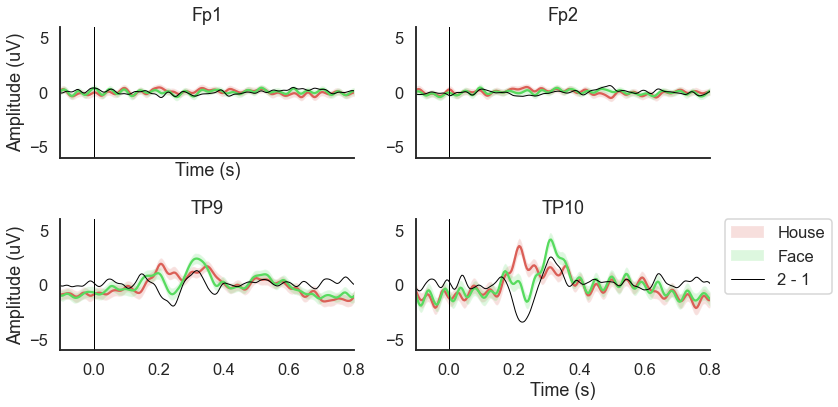

In [32]:
# put them together before visualization
epochs_all = mne.concatenate_epochs(list(epochs.values()))

conditions = OrderedDict()
conditions['House'] = [1] 
conditions['Face'] = [2]

fig, ax = plot_conditions(epochs_all, conditions=conditions, 
                          ci=97.5, n_boot=1000, title='',
                          diff_waveform=(1, 2),
                          channel_order=[1, 0, 2, 3])

And there! That's the visualization of all of the trials that we have. 